In [74]:
using CSV
using DataFrames
using Turing
using MCMCChains
using Plots
using StatsPlots
using StatsBase
using Distributions
using NPZ

   Resolving package versions...
    Updating `~/.julia/environments/v1.7/Project.toml`
  [2913bbd2] + StatsBase v0.33.16
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


## Importing ##

In [90]:
spiketimes = npzread("spikeAndBehavioralData/allData/Cori_2016-12-14/spikes.times.npy")[:]
clusterids = npzread("spikeAndBehavioralData/allData/Cori_2016-12-14/spikes.clusters.npy")[:]

10017476-element Vector{Int32}:
  527
  487
  243
  510
  435
  107
  504
  277
   67
  485
  455
  502
  491
    ⋮
  780
  775
 1012
 1070
  771
  593
  775
  652
  821
 1008
  813
  570

## Preprocessing ## 

In [91]:
indexes = unique(clusterids)

firing_rates = [0 for i=0:length(indexes)-1]

for n in 1:length(clusters)
    index = clusterids[n]
    firing_rates[index+1] += 1
end

frequency = firing_rates/times[length(times)]

1085-element Vector{Float64}:
  0.30562673306126037
  1.0426829706617817
  1.4626422225074605
  0.23902526580820121
  1.8959217678037508
  1.0112322777922815
  0.4125590888175609
  0.1690937251924891
  2.1848981340517466
  3.8129340002376373
  1.4241613747612485
  0.4532599854722082
  2.480534647025048
  ⋮
  1.0748736798340937
  1.486322744197437
  0.9379706638139166
  1.1725558318052471
  1.3890106003776894
  2.54417604906686
  0.8872795470713104
 30.407269882535566
  1.3120489048852655
  0.600893237883156
  0.38591850191633725
  1.4452518393913838

## Visualization ##  

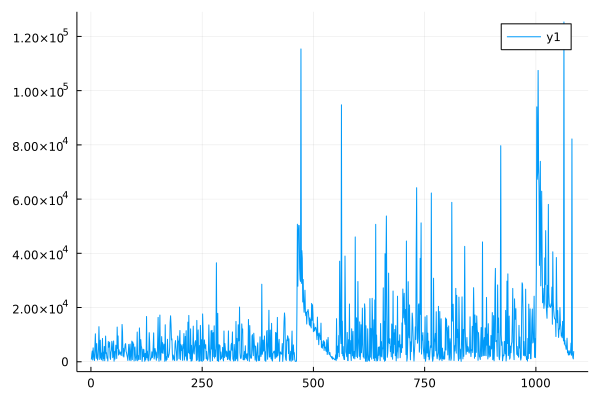

In [92]:
plot(firing_rates)

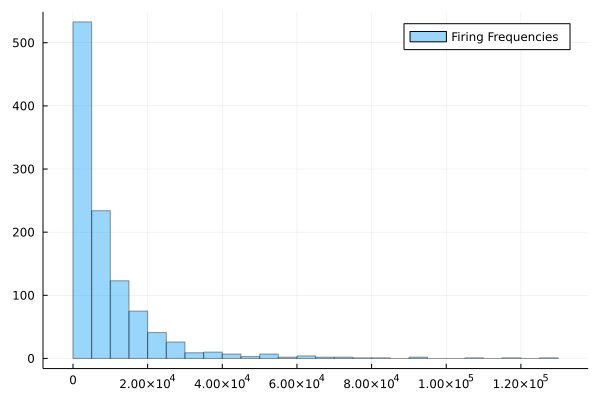

In [93]:
histogram(firing_rates, bins=50, alpha=0.4, label="Firing Frequencies")

## Modeling ##

$f_i$ is a frequency

$$P(\lambda | f_i) \propto P(f_i | \lambda)P(\lambda)$$

This is the likelihood:
$$f_i \sim Exponential(\lambda)$$

This is the prior:
$$\lambda \sim Gamma(2, 2)$$

In [94]:
@model function firing_model(frequency, ::Type{T} = Int32) where {T <: Int32}
    # Prior
    lambda ~ Gamma(1, 4)

    # Likelihood
    for i in eachindex(frequency)
        frequency[i] ~ Exponential(lambda)
    end
    
    return frequency 
end

firing_model (generic function with 3 methods)

In [95]:
md = firing_model(frequency)
chain = sample(md, NUTS(0.65), MCMCThreads(), 1000, 4)

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/alex/.julia/packages/AbstractMCMC/fnRmh/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/alex/.julia/packages/Turing/JdESU/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /home/alex/.julia/packages/Turing/JdESU/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /home/alex/.julia/packages/Turing/JdESU/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /home/alex/.julia/packages/Turing/JdESU/src/inference/hmc.jl:188
Sampling (1 threads): 100%|█████████████████████████████| Time: 0:00:00


Chains MCMC chain (1000×13×4 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 4
Samples per chain = 1000
Wall duration     = 3.66 seconds
Compute duration  = 3.48 seconds
parameters        = lambda
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

      lambda    3.4188    0.1047     0.0017    0.0027   1664.3281    1.0050    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

      lambda    3.2207    3.3464    3.4171    3.4891    3.6276


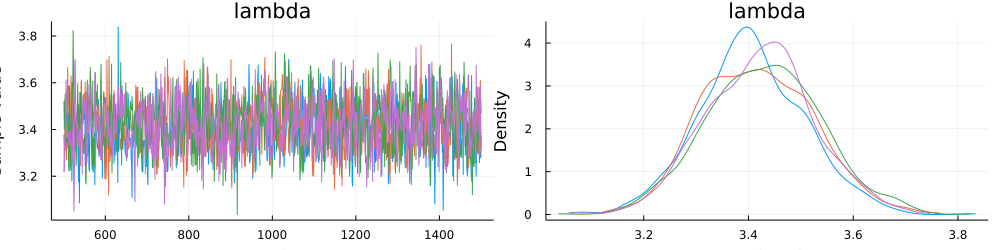

In [96]:
plot(chain)